<a href="https://colab.research.google.com/github/michalburdzy/fastai/blob/main/bird_or_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 17.9 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from pathlib import Path

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
search_images("duck", 1)

Searching for 'duck'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


(#1) ['http://upload.wikimedia.org/wikipedia/commons/7/74/White_domesticated_duck,_stretching.jpg']

In [14]:
from fastdownload import download_url
duck_destination = "duck.jpg"
download_url(search_images("duck", 1)[0], duck_destination, show_progress=False)
forest_destination = "forest.jpg"
download_url(search_images("forest photo", 1)[0], forest_destination, show_progress=False)

Searching for 'duck'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'forest photo'


Path('forest.jpg')

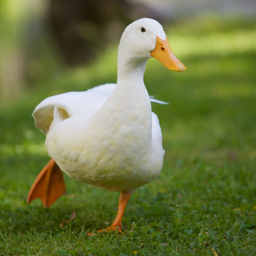

In [15]:
from fastai.vision.all import *
duck_image = Image.open(duck_destination)
duck_image.to_thumb(256,256)

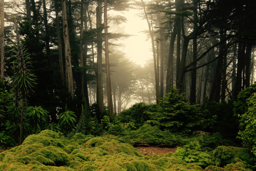

In [16]:
forest_image = Image.open(forest_destination)
forest_image.to_thumb(256,256)

In [6]:
searches = ("forest","bird")
modifiers = ("photo", "sun photo", "shade photo", "beautiful photo")
path = Path("forest_or_bird")
from time import sleep

for term in searches:
  destination = path/term
  destination.mkdir(exist_ok=True, parents=True)

  for modifier in modifiers:
    download_images(destination, urls=search_images(f'{term} {modifier}'))
    sleep(5)

  resize_images(destination, max_size=400, dest=destination)

Searching for 'forest photo'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'forest beautiful photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
Searching for 'bird beautiful photo'


In [7]:
failed_images = verify_images(get_image_files(path))
failed_images.map(Path.unlink)
len(failed_images)

4

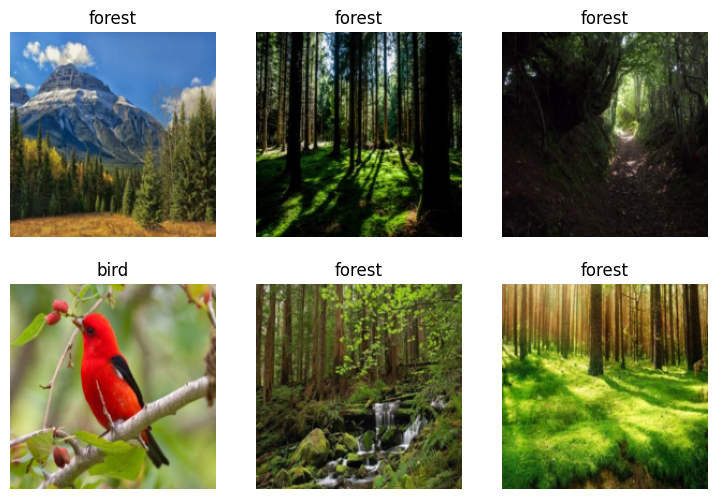

In [8]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
)
dataloaders = datablock.dataloaders(path, bs=32)
dataloaders.show_batch(max_n=6)

In [9]:
learner = vision_learner(dataloaders, resnet18, metrics=error_rate)
learner.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.735965,0.409519,0.066667,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.131956,0.071601,0.044444,00:02
1,0.065986,0.043618,0.044444,00:01
2,0.043713,0.048131,0.022222,00:01


In [17]:
predicted_label, is_forest, probs = learner.predict(PILImage.create(duck_destination))
print(f"Predicted label: {predicted_label}")
print(f"Probablilities: {probs}")

Predicted label: bird
Probablilities: tensor([0.9954, 0.0046])


In [18]:
predicted_label, is_forest, probs = learner.predict(PILImage.create(forest_destination))
print(f"Predicted label: {predicted_label}")
print(f"Probablilities: {probs}")

Predicted label: forest
Probablilities: tensor([5.7734e-04, 9.9942e-01])
